In [12]:
import pandas as pd
import numpy as np
import yfinance as yf
import ta
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import History
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, LSTM, Activation 
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [13]:
def load_data():
    data = pd.read_csv('/Users/samuelzobev/Downloads/End of year project/data_collection/MSFT.csv', date_parser=True)
    data['RSI'] = ta.momentum.RSIIndicator(data['Close'], window=14).rsi()
    data['MA'] = ta.trend.SMAIndicator(data['Close'], window=20).sma_indicator()
    data['EMA'] = ta.trend.EMAIndicator(data['Close'], window=20).ema_indicator()
    bb = ta.volatility.BollingerBands(data['Close'], window=20, window_dev=2)
    data['BB_upper'] = bb.bollinger_hband()
    data['BB_middle'] = bb.bollinger_mavg()
    data['BB_lower'] = bb.bollinger_lband()
    data = data[['Date', 'Open', 'Close', 'High', 'Low', 'Volume', 'Adj Close', 'RSI', 'MA', 'EMA', 'BB_upper', 'BB_middle', 'BB_lower']]
    data = data.set_index('Date')
    data = data.dropna()
    return data

In [14]:
# remove NaN values
def preprocess_data(data):
    train_size = int(len(data) * 0.7)
    train_data, test_data = data.iloc[:train_size], data.iloc[train_size:]
    scaler = MinMaxScaler()
    train_data = scaler.fit_transform(train_data)
    test_data = scaler.transform(test_data)
    return train_data, test_data, scaler

# prepare the data for LSTM
def prepare_data(data, window_size, num_steps):
    X, Y = [], []
    for i in range(len(data) - window_size - num_steps + 1):
        X.append(data[i:(i + window_size), :])
        Y.append(data[(i + window_size):(i + window_size + num_steps), 1])  # predict 'num_steps' Close values
    X = np.array(X)
    Y = np.array(Y)
    return X, Y


In [15]:
def build_model(trainX, num_steps):
    model = Sequential()
    model.add(LSTM(64, activation='sigmoid', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(64, activation='sigmoid', return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(64, activation='sigmoid', return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(num_steps)) 
    model.compile(optimizer='adam', loss='mse', metrics=['mse'])
    return model

In [16]:
def train_model(model, trainX, trainY, testX, testY):
    history = model.fit(trainX, trainY, epochs=2000, batch_size=100, shuffle=True, validation_data=(testX, testY), verbose=2)
    return history

In [17]:
def evaluate_model(model, testX, testY, train_data, scaler, num_steps):
    predictions = model.predict(testX)
    dummy_cols_pred = np.zeros((predictions.shape[0], train_data.shape[1] - num_steps))
    predictions = np.hstack((predictions, dummy_cols_pred))
    unscaled_predictions = scaler.inverse_transform(predictions)[:, :num_steps]
    dummy_cols_actual = np.zeros((testY.shape[0], train_data.shape[1] - num_steps))
    actual = np.hstack((testY, dummy_cols_actual))
    unscaled_actual = scaler.inverse_transform(actual)[:, :num_steps]
    mse = mean_squared_error(unscaled_actual, unscaled_predictions)
    mae = mean_absolute_error(unscaled_actual, unscaled_predictions)
    mape = np.mean(np.abs((unscaled_actual - unscaled_predictions) / unscaled_actual)) * 100
    rmse = np.sqrt(mse)
    r2_score = 1 - (np.sum((unscaled_actual - unscaled_predictions)**2) / np.sum((unscaled_actual - np.mean(unscaled_actual))**2))
    if num_steps > train_data.shape[1]:
        raise ValueError(f"Can't predict {num_steps} steps ahead. The maximum number of steps is {train_data.shape[1]}.")
    return mse, mae, mape, rmse, r2_score, unscaled_predictions, unscaled_actual

In [18]:
def save_model(model):
    model.save(r'trained_models/trained_model.h14')

In [19]:
# Load the data
data = load_data()
# Preprocess the data
train_data, test_data, scaler = preprocess_data(data)

In [20]:
# Prepare the data for LSTM
window_size = 7  # Use 7 previous time steps as input features
num_steps = 1  # Predict 1 future time steps
trainX, trainY = prepare_data(train_data, window_size, num_steps)
testX, testY = prepare_data(test_data, window_size, num_steps)
# Build the LSTM model
model = build_model(trainX, num_steps)

Epoch 1/2000
6/6 - 2s - loss: 0.1642 - mse: 0.1642 - val_loss: 0.1128 - val_mse: 0.1128 - 2s/epoch - 379ms/step
Epoch 2/2000
6/6 - 0s - loss: 0.1677 - mse: 0.1677 - val_loss: 0.0795 - val_mse: 0.0795 - 72ms/epoch - 12ms/step
Epoch 3/2000
6/6 - 0s - loss: 0.1228 - mse: 0.1228 - val_loss: 0.0948 - val_mse: 0.0948 - 71ms/epoch - 12ms/step
Epoch 4/2000
6/6 - 0s - loss: 0.1189 - mse: 0.1189 - val_loss: 0.0709 - val_mse: 0.0709 - 74ms/epoch - 12ms/step
Epoch 5/2000
6/6 - 0s - loss: 0.1157 - mse: 0.1157 - val_loss: 0.0739 - val_mse: 0.0739 - 84ms/epoch - 14ms/step
Epoch 6/2000
6/6 - 0s - loss: 0.1137 - mse: 0.1137 - val_loss: 0.0766 - val_mse: 0.0766 - 70ms/epoch - 12ms/step
Epoch 7/2000
6/6 - 0s - loss: 0.1147 - mse: 0.1147 - val_loss: 0.0735 - val_mse: 0.0735 - 69ms/epoch - 12ms/step
Epoch 8/2000
6/6 - 0s - loss: 0.0990 - mse: 0.0990 - val_loss: 0.0698 - val_mse: 0.0698 - 73ms/epoch - 12ms/step
Epoch 9/2000
6/6 - 0s - loss: 0.1086 - mse: 0.1086 - val_loss: 0.0707 - val_mse: 0.0707 - 72ms/ep

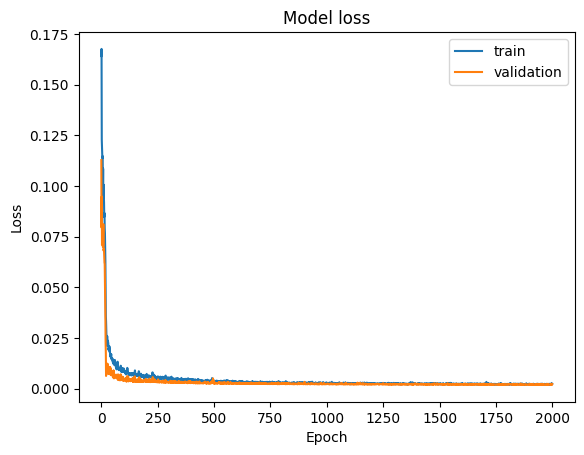

In [21]:
# Train the model
history = train_model(model, trainX, trainY, testX, testY)
# Graph loss and validation loss in one graph
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()


7/7 [==============================] - 0s 2ms/step
MSE: 46.8830940722015 MAE: 5.28168621385256 MAPE: 1.9574852371119449 RMSE: 6.847123050756537 R2 Score: 0.9699421474156863


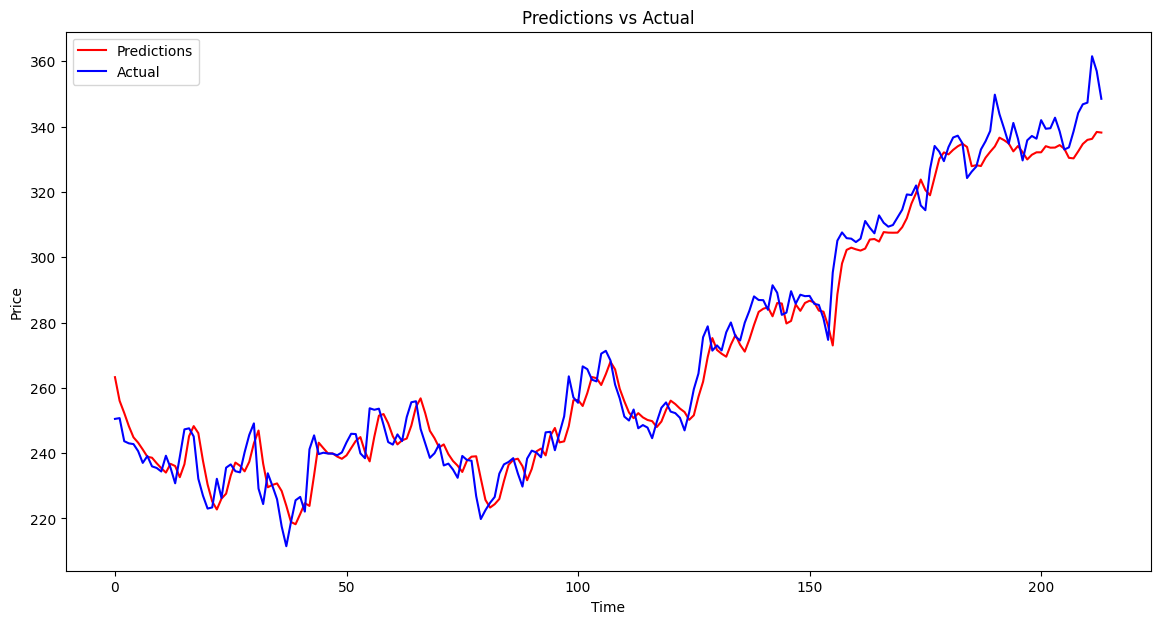

INFO:tensorflow:Assets written to: trained_models/trained_model.h14/assets


INFO:tensorflow:Assets written to: trained_models/trained_model.h14/assets


In [22]:
# Evaluate the model
from turtle import color


mse, mae, mape, rmse, r2_score, unscaled_predictions, unscaled_actual = evaluate_model(model, testX, testY, train_data, scaler, num_steps)
print('MSE:', mse, 'MAE:', mae, 'MAPE:', mape,'RMSE:', rmse, 'R2 Score:', r2_score)

# Plot the predictions
plt.figure(figsize=(14, 7))
plt.plot(unscaled_predictions, label='Predictions', color='red')
plt.plot(unscaled_actual, label='Actual', color='blue')
plt.title('Predictions vs Actual')
plt.ylabel('Price')
plt.xlabel('Time')
plt.legend(loc='upper left')
plt.show()

# Save the model
save_model(model)